/tmp/ipython-input-246989155.py:14: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort=True)


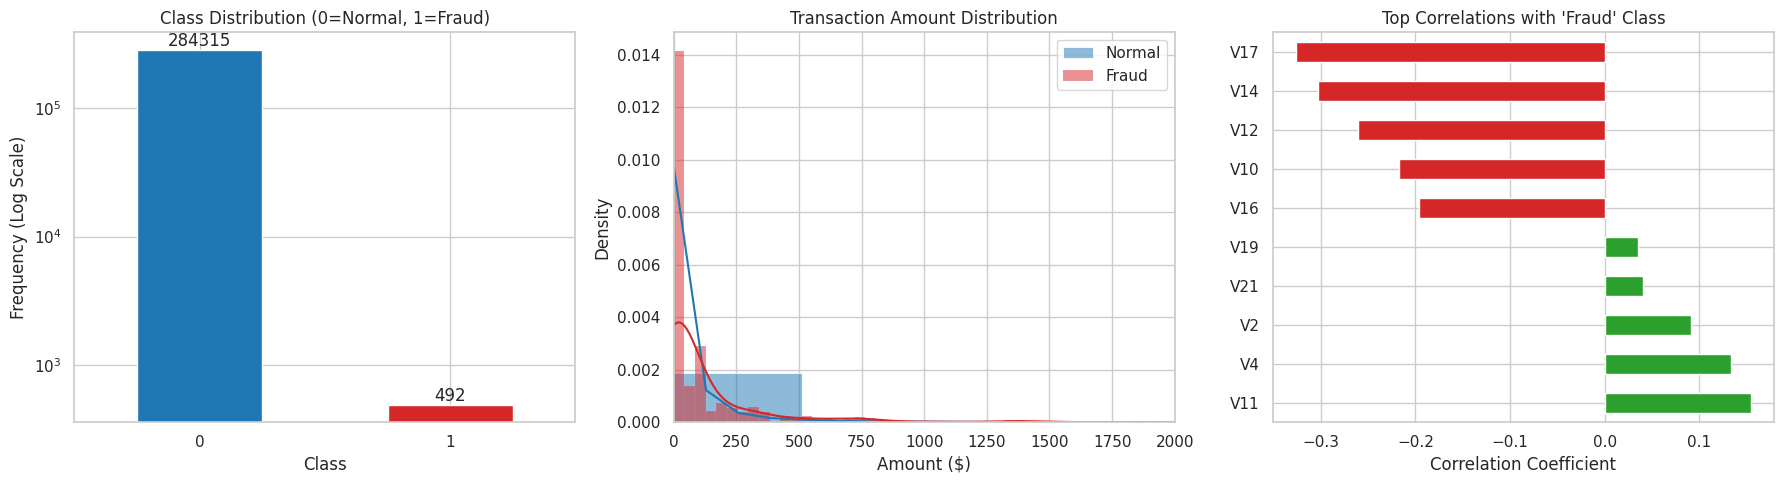

Statistici Cheie:
Fraude totale: 492 (0.173%)
Tranzacții Normale: 284315


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Încărcare (Asigură-te că fișierul e în folder)
df = pd.read_csv('/content/sample_data/creditcard.csv')

# Setări vizuale
sns.set(style="whitegrid")
plt.figure(figsize=(18, 5))

# --- GRAFIC 1: Dezechilibrul Extrem (Class Distribution) ---
plt.subplot(1, 3, 1)
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind='bar', rot=0, color=['#1f77b4', '#d62728'])
plt.title("Class Distribution (0=Normal, 1=Fraud)")
plt.yscale('log') # Folosim scală logaritmică pentru a vedea bara mică roșie
plt.xlabel("Class")
plt.ylabel("Frequency (Log Scale)")
plt.text(0, count_classes[0], f"{count_classes[0]}", ha='center', va='bottom')
plt.text(1, count_classes[1], f"{count_classes[1]}", ha='center', va='bottom')

# --- GRAFIC 2: Suma Tranzacțiilor (Amount) ---
plt.subplot(1, 3, 2)
# Filtrăm doar tranzacțiile sub 2500$ pentru vizibilitate
sns.histplot(df[df['Class']==0]['Amount'], bins=50, color='#1f77b4', label='Normal', stat="density", kde=True)
sns.histplot(df[df['Class']==1]['Amount'], bins=50, color='#d62728', label='Fraud', stat="density", kde=True)
plt.title("Transaction Amount Distribution")
plt.xlim(0, 2000)
plt.xlabel("Amount ($)")
plt.legend()

# --- GRAFIC 3: Corelații (Heatmap) ---
plt.subplot(1, 3, 3)
# Calculăm corelația doar cu ținta (Class)
correlations = df.corrwith(df['Class']).sort_values(ascending=False)
# Excludem 'Class' din grafic și luăm top 5 pozitive și top 5 negative
top_corr = pd.concat([correlations.head(6), correlations.tail(5)]).drop('Class')
top_corr.plot(kind='barh', color=np.where(top_corr > 0, '#2ca02c', '#d62728'))
plt.title("Top Correlations with 'Fraud' Class")
plt.xlabel("Correlation Coefficient")

plt.tight_layout()
plt.savefig('eda_plots.png')
plt.show()

print("Statistici Cheie:")
print(f"Fraude totale: {df['Class'].sum()} ({df['Class'].mean()*100:.3f}%)")
print(f"Tranzacții Normale: {len(df) - df['Class'].sum()}")

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix

# 1. ÎNCĂRCARE
file_path = '/content/sample_data/creditcard.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset Credit Card Fraud încărcat.")
except FileNotFoundError:
    print(f"Nu găsesc '{file_path}'.")
    raise

df.dropna(inplace=True)

# 2. PREPROCESARE
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

X = df.drop('Class', axis=1)
y = df['Class']

# Split
try:
    X_big, X_sample, y_big, y_sample = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
except ValueError:
    X_big, X_sample, y_big, y_sample = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Subset de lucru: {len(X_sample)} tranzacții.")

X_tv, X_test, y_tv, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42, stratify=y_sample)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=0.3, random_state=42, stratify=y_tv)

# 3. ANTRENARE MODELE
print("Antrenare...")
lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

gb = GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42)
gb.fit(X_train, y_train)

# 4. PSO AVANSAT: Caută Ponderi + PRAG
print("Optimizare PSO (Ponderi + Prag)...")

p1_val = lr.predict_proba(X_val)[:, 1]
p2_val = rf.predict_proba(X_val)[:, 1]
p3_val = gb.predict_proba(X_val)[:, 1]

def fitness_advanced(particle):
    # Primele 3 sunt ponderi, a 4-a este pragul (threshold)
    weights = particle[:3]
    threshold = particle[3]

    # Validare threshold (între 0.01 și 0.99)
    if threshold <= 0.01 or threshold >= 0.99:
        return 0.0 # Penalizare maximă

    w = np.maximum(weights, 0)
    if np.sum(w) == 0: return 0.0
    w /= np.sum(w)

    final_prob = (w[0]*p1_val + w[1]*p2_val + w[2]*p3_val)

    # AICI E CHEIA: Folosim pragul din particulă, nu 0.5
    y_pred = (final_prob >= threshold).astype(int)

    return -f1_score(y_val, y_pred)

# Setări PSO - 4 Dimensiuni
n_dim = 4 # [w1, w2, w3, THRESHOLD]
n_part = 25
max_iter = 30

# Initializare
X_pso = np.random.uniform(0, 1, size=(n_part, n_dim))
# Forțăm pragul să înceapă în zona 0.3-0.7
X_pso[:, 3] = np.random.uniform(0.3, 0.7, size=n_part)

V_pso = np.random.uniform(-0.1, 0.1, size=(n_part, n_dim))
P_best = X_pso.copy()
P_best_scores = np.array([fitness_advanced(p) for p in X_pso])
G_best = P_best[np.argmin(P_best_scores)].copy()
G_best_score = np.min(P_best_scores)

for t in range(max_iter):
    r1, r2 = np.random.rand(n_part, n_dim), np.random.rand(n_part, n_dim)
    V_pso = 0.6*V_pso + 1.4*r1*(P_best - X_pso) + 1.4*r2*(G_best - X_pso)
    X_pso = X_pso + V_pso

    # Clip weights [0,1], Clip threshold [0.01, 0.99]
    X_pso[:, :3] = np.clip(X_pso[:, :3], 0.0, 1.0)
    X_pso[:, 3] = np.clip(X_pso[:, 3], 0.01, 0.99)

    scores = np.array([fitness_advanced(p) for p in X_pso])
    better = scores < P_best_scores
    P_best[better] = X_pso[better]
    P_best_scores[better] = scores[better]
    if np.min(scores) < G_best_score:
        G_best = X_pso[np.argmin(scores)].copy()
        G_best_score = np.min(scores)

# Extragere soluție optimă
best_w = np.maximum(G_best[:3], 0)
best_w /= np.sum(best_w)
best_threshold = G_best[3]

# 5. EVALUARE FINALĂ
p1_test = lr.predict_proba(X_test)[:, 1]
p2_test = rf.predict_proba(X_test)[:, 1]
p3_test = gb.predict_proba(X_test)[:, 1]

f1_lr = f1_score(y_test, lr.predict(X_test))
f1_rf = f1_score(y_test, rf.predict(X_test))
f1_gb = f1_score(y_test, gb.predict(X_test))

# PSO cu Prag Optimizat
final_prob = (best_w[0]*p1_test + best_w[1]*p2_test + best_w[2]*p3_test)
y_pred_pso = (final_prob >= best_threshold).astype(int)
f1_pso = f1_score(y_test, y_pred_pso)

print(f"\n--- Rezultate PSO Advanced (Threshold Tuning) ---")
print(f"Ponderi: LR={best_w[0]:.2f}, RF={best_w[1]:.2f}, GB={best_w[2]:.2f}")
print(f"Prag Optim Găsit: {best_threshold:.4f} (Standard e 0.5)")
print(f"Logistic Regression F1: {f1_lr:.4f}")
print(f"Random Forest F1:       {f1_rf:.4f}")
print(f"Gradient Boosting F1:   {f1_gb:.4f}")
print(f"PSO Advanced F1:        {f1_pso:.4f}")

baseline_best = max(f1_lr, f1_rf, f1_gb)
print(f"Creștere față de cel mai bun model: +{f1_pso - baseline_best:.4f}")

Dataset Credit Card Fraud încărcat.
Subset de lucru: 56962 tranzacții.
Antrenare (poate dura 1 min)...
Optimizare PSO (Ponderi + Prag)...

--- Rezultate PSO Advanced (Threshold Tuning) ---
Ponderi: LR=0.48, RF=0.52, GB=0.00
Prag Optim Găsit: 0.6093 (Standard e 0.5)
Logistic Regression F1: 0.2358
Random Forest F1:       0.7547
Gradient Boosting F1:   0.5246
PSO Advanced F1:        0.8136
Creștere față de cel mai bun model: +0.0588
